In [1]:
from __future__ import print_function

#####importing the necessary libraries
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import time
import pickle

In [4]:
def Create_Data_INCUBE(npt,nptx=0,npty=0,nptz=0,structure='grid'):
    '''This creates data inside a unit cube
     one can just provide the npt which is npt per axis.
     But if you would like the number of points to be different on any axis then use the 
     corresponding axis nptx,npty,nptz to have a different number of points.
     One can also choose the structure of data with
     structure='grid' to generate a regular grid and
     structure='random' to generate random points within the cube 
     it returns the xyz coordinates and the maximum sideL based on npt on each axis'''
    
    #update the number of points in each axis
    if(nptx==0):
        nptx=npt
    if(npty==0):
        npty=npt
    if(nptz==0):
        nptz=npt
        
    if(structure=='grid'):
        #linearly space points in each axis
        xspace=np.linspace(0,1,nptx)
        yspace=np.linspace(0,1,npty)
        zspace=np.linspace(0,1,nptz)
        
        #create a 3d grid using linearly space points
        px,py,pz=np.meshgrid(xspace,yspace,zspace)
        #Reshape the 3d array to 1d array
        px=px.reshape(px.size)
        py=py.reshape(py.size)
        pz=pz.reshape(pz.size)    
    elif(structure=='random'):
        #total number of points
        npt3d=nptx*npty*nptz
        #create random points for each of the axis
        px=np.random.random(npt3d)
        py=np.random.random(npt3d)
        pz=np.random.random(npt3d)
        
    #stack the x-y-z co-ordinates in one array
    pxyz=np.column_stack([px,py,pz])
    
    #size of sideL
    sideLxyz=np.array([1.0/(nptx-1),1.0/(npty-1),1.0/(nptz-1)])
    sideL=np.max(sideLxyz)
    
    return pxyz ,sideL
        
       

def Draw_unit_cube_perspective(pxyz,sideL,gridon=1,plots=1):
    '''This draws unit cube with a perpsective in 2D''' 

    #get the vertices of a unit cube
    box_point={0:np.array([0,0,0]),1:np.array([0,0,1]),2:np.array([0,1,0]),3:np.array([1,0,0]),
           4:np.array([0,1,1]),5:np.array([1,0,1]),6:np.array([1,1,0]),7:np.array([1,1,1])}

    #define the rotation angles for the purpose of visualization only
    theta_x=2.0*np.pi/10.0
    theta_y=1.0*np.pi/20.0
    theta_z=0.0*np.pi/10.0

    #define the rotation matrix
    Rx=np.array([[1,0,0],
                 [0,np.cos(theta_x),-np.sin(theta_x)],
                [0,np.sin(theta_x),np.cos(theta_x)]])

    Ry=np.array([[np.cos(theta_y),0,np.sin(theta_y)],
                [0,1,0],
                [-np.sin(theta_y),0,np.cos(theta_y)]])

    Rz=np.array([[np.cos(theta_z),-np.sin(theta_z),0],
                [np.sin(theta_z),np.cos(theta_z),0],
               [0,0,1]])

    #initiate a figure
    pl.figure(figsize=(10,10))

    #Draw the edges of the cube
    for ii,aa in enumerate(box_point.keys()):
        for jj,bb in enumerate(box_point.keys()):
            diff=np.abs(box_point[aa]-box_point[bb])
            if(np.sum(diff)==1):
                v1=np.matmul(np.matmul(Rx,Ry),box_point[aa])
                v2=np.matmul(np.matmul(Rx,Ry),box_point[bb])
                pl.plot([v1[0],v2[0]],[v1[1],v2[1]],'k-',lw=2)


    #Draw the input points and connect the nearest points if grid is on
    for ii in range(0,pxyz.shape[0]):
        vthis=pxyz[ii,:]
        #Rotate the point for perspective
        vrot=np.matmul(np.matmul(Rx,Ry),vthis)
        #plot the point
        pl.plot(vrot[0],vrot[1],color='r',marker='o',markersize=10)
        
        #Now if grid is needed then run this part to plot grid of nearest neigbour
        if(gridon==1):
            #Look at all the other points
            for jj in range(ii,pxyz.shape[0]):
                vjj=pxyz[jj,:]
                #Rotate the point for perspective
                vrot_jj=np.matmul(np.matmul(Rx,Ry),vjj)
                #See if this is within the sideL of the input
                dist=np.sqrt(np.sum(np.power(vjj-vthis,2)))
                if(dist<=1.01*sideL and dist>0):
                    #plot a line connecting if within sideL
                    pl.plot([vrot[0],vrot_jj[0]],[vrot[1],vrot_jj[1]],color='r',ls='-',alpha=0.6)
        
    pl.axis('off')
    #pl.axis('equal')
        
    return 

The above two distribution of points are different and its easy to see that because we have small number of points and difference is quite large. We would like to think about how to distinguish between the two in a statistical way. 

## Pair Counting: Count the number pair of points as the function of distance

pair counting for large number of points is an expensive and tricky process. A lot of public code and tricks are involved to do it efficiently. In this tutorial we are using one such code but later you can explore other options. The next cell just import some necessary libraries and define a function necessary to do the pair count. You should try to just understand how to use it rather than how it works in the first go and later if you have time and inclination then you can try to understand how it works.

In [5]:
import sys
sys.path.insert(0, './CorrelationFunction')
import ccorr_utility as corrutility
import General_FITS_selection as GFS
import ccorr

def get_paircount(pxyz1,rlim=[0,0.3,0,1.0],nbins=[20,1],blen=[1.0,1.0,1.0],
                  POS_min=[0,0,0],sampmode=0,njn=0,pbc=1,los=0,interactive=1,plots=0):
    
    ''' This performs the pair count and return the array with first column as seperation and second column as number of pair 
    sampmode= 0=rmu , 1=rpara-rperp, 2=rtheta, 
    3=log(rpar)-rperp (The range of r_perp in samplim should be entered in the log space), 
    4=log(r)-theta (The range of r in samplim should be entered in the log space)'''
    
    nhocells=3
    fp1=0
    fp2=0
    lp1=pxyz1.shape[0]
    lp2=pxyz1.shape[0]
    
    data1=np.column_stack([pxyz1,np.ones(lp1)])
    
    data_c = np.ascontiguousarray(data1[:,[0,1,2,3]], dtype=np.float64)
    data2_c=np.copy(data_c)
    
    rlim_c =np.ascontiguousarray(np.array(rlim,dtype='double'))
    blen_c =np.ascontiguousarray(np.array(blen,dtype='double'))
    pos_min_c=np.ascontiguousarray(np.array(POS_min,dtype='double'))


    if(1):
        pc= ccorr.corr2dpy(data_c, fp1, lp1, data_c, fp2, lp2, rlim_c, nbins[0],nbins[1], nhocells,
                 blen_c, pos_min_c, sampmode, njn,
                 pbc,los,interactive)
        
    if(nbins[1]!=1):
        return pc
    
    rbin_ed=np.linspace(rlim[0],rlim[1],nbins[0]+1)
    rbin_mid=0.5*(rbin_ed[1:]+rbin_ed[:-1])
    if(plots==1):
        pl.plot(rbin_mid,pc)
    
    return np.column_stack([rbin_mid,pc])

# <font size=5, color='blue'> Work 1: Generating data and pair counting </font>
Now let us write the code to generate a two data set one with grid structure and other with random structure with npt=21 using the function <font size=3, color='green', weight='light'>  Create_Data_INCUBE </font> 

Then count the number of pair of points as the function of distance using the function <font size=3, color='green', weight='light'>  get_paircount </font>  and finally plot them.


(0, 0.3)

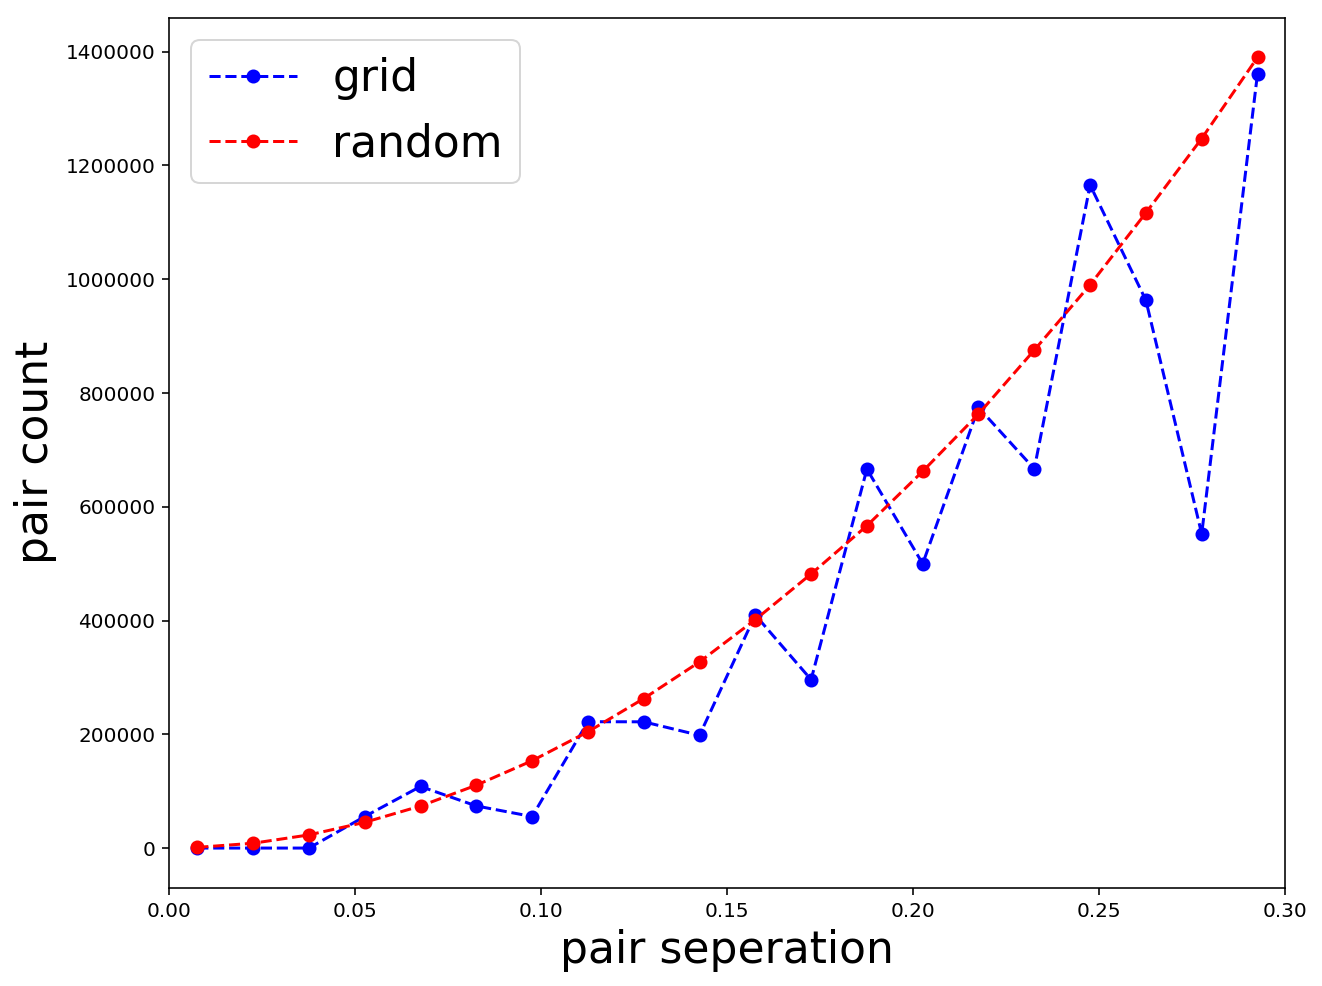

In [6]:
#use this space to write the code for work 1

#Solution Work 1:
pxyz_g, ag=Create_Data_INCUBE(21,nptx=0,npty=0,nptz=0,structure='grid')
pxyz_r, ar=Create_Data_INCUBE(21,nptx=0,npty=0,nptz=0,structure='random')

#get the paircount
pcg=get_paircount(pxyz_g,nbins=[20,1])
pcr=get_paircount(pxyz_r,nbins=[20,1])


#make plot
pl.figure(figsize=(10,8))
pl.plot(pcg[:,0],pcg[:,1],'bo--',label='grid')
pl.plot(pcr[:,0],pcr[:,1],'ro--',label='random')
pl.xlabel('pair seperation',fontsize=22)
pl.ylabel('pair count',fontsize=22)
pl.legend(fontsize=22,loc=2)

pl.xlim([0,0.3])

In [8]:
path="./../../../DLA Mock Catalogue/"
path2="./../Data/"
fileNames=["DLAhost_snap49_r1_b1 (copy).txt","DLAhost_snap49_r1_b1alpha (copy).txt","DLAhost_snap49_r1_b1T10 (copy).txt"]
boxsize=150.0
maxLength=np.sqrt(3)*boxsize
eps=1.0

In [14]:
def shadabCorr(dataDD,dR=2.0):
    start=time.time()
    nb=int(maxLength/dR)
    rlim_=[0,0.6,0,0]
    dataRR,ar=Create_Data_INCUBE(int(np.cbrt(len(pos))),nptx=0,npty=0,nptz=0,structure='random')
    dataDD=dataDD/boxsize
    
    pcDD=get_paircount(dataDD)
    pcRR=get_paircount(dataRR)
    
#    pcDD=get_paircount(dataDD,rlim=rlim_)
#    pcRR=get_paircount(dataRR,rlim=rlim_)
    
    pcDD_=np.array(pcDD[:,1],dtype='double')+eps
    pcRR_=np.array(pcRR[:,1],dtype='double')+eps
    
    end=time.time()
    print("Correlation found in: "+str(end-start)+" seconds")
    s_corr=(pcDD_/pcRR_)-1.0
    return pcDD[:,0]*boxsize,s_corr

In [15]:
# Reference : https://stackoverflow.com/questions/6159900/correct-way-to-write-line-to-file
def writeFileMine(bins,corrs,index):
    outname="./SHDB "+fileNames[index]
    with open(outname,'w') as o:
        o.write("# SHDB 2 point correlation for input file: "+fileNames[index]+"\n")
        o.write("# Separation[R]     Correlation Value[Xi(R)]\n")
        for b,c in zip(bins,corrs):
            o.write(str(b)+" "+str(c)+"\n")
    print("Written to file")

In [16]:
for i in range(0,len(fileNames)):
    fname=path+fileNames[i]+"_pickled"
    pos=pickle.load(open(fname,'rb'))
    b,c=shadabCorr(pos)
    writeFileMine(b,c,i)

Correlation found in: 17.513079166412354 seconds
Written to file
Correlation found in: 1.4448184967041016 seconds
Written to file
Correlation found in: 98.15267610549927 seconds
Written to file


In [ ]:
#make plot
pl.figure(figsize=(10,8))
pl.plot(pcg[:,0],pcg[:,1],'bo--',label='grid')
pl.plot(pcr[:,0],pcr[:,1],'ro--',label='random')
pl.xlabel('pair seperation',fontsize=22)
pl.ylabel('pair count',fontsize=22)
pl.legend(fontsize=22,loc=2)

pl.xlim([0,0.3])

# Modeling the Pair count

## Give an expression for pair count as the function of distance in a unit box with $N_R$ number of points


<img src="../images/Analytic_pc_randoms.png" alt="drawing" width="700"/>

# <font size=5, color='blue'> Work 2: Analytic expression for Pair counting a random distribution </font>
Now write a function to evaluate the pair count for a random distribution given bin edges, side legnth and number of random points. The function should have following structure:

```python
def Model_PairCount_random(rbin_ed,NR=1, sideL=1.0):
    '''This should return array with two columns the first column corresponding to the mid point of r bins and the second column should give the analytical pair count for randoms.'''
    return model_pc
```

Also make a plot comparing the result from your analytic count with previous numerically computed results for random distribution.

In [ ]:
#use this space to write the code for work 2

#solution to Work 2:
def Model_PairCount_random(rbin_ed,NR=1, sideL=1.0,plots=1):
    '''This evaluates the expression for number of pair count in radial bin for a random distribution'''
    
    #mid point of the radial bin
    rbin_mid=0.5*(rbin_ed[1:]+rbin_ed[:-1])
    
    #density of points
    density=(NR-1.0)/np.power(sideL,3)
    
    #volume of shells
    vol_shell=(np.pi*4.0/3.0)*(np.power(rbin_ed[1:],3)-np.power(rbin_ed[:-1],3))
    
    pair_count=NR*vol_shell*density
    
    if(plots==1):
        pl.plot(rbin_mid,pair_count,'bs')
        
    return np.column_stack([rbin_mid,pair_count])

rbin_ed=np.linspace(0,0.3,21)
MpcR=Model_PairCount_random(rbin_ed,NR=np.power(21,3), sideL=1.0,plots=1)
pl.plot(pcr[:,0],pcr[:,1],'ro--',label='random')
print(pxyz_r.shape,np.power(21,3))

# Fundamental two point modes of a infinite cubic lattice

<img src="../images/modes-of-cube.png" alt="drawing" width="700"/>

A of cube side length $a$ will have following fundamental modes

<ol type="A">
    <li>Edge modes:  $a$</li>
    <li>Face modes:  $\sqrt{\alpha^2 + \beta^2} a$ </li>
    <li>Diagonal modes: $\sqrt{\alpha^2 + \beta^2 + \gamma^2} a$</li>
</ol>

where $\alpha$, $\beta$  and $\gamma$ are positive integers. It will be useful to remember two number theory theorems at this point.

# <font size=3, color='blue'> Theorem 1: Sum of two squares theorem </font>

An integer greater than one can be written as a sum of two squares if and only if its prime decomposition contains no prime congruent to  3 (mod 4) raised to an odd power.

for more details: #https://en.wikipedia.org/wiki/Sum_of_two_squares_theorem


# <font size=3, color='blue'> Theorem 2: Legendre's three-square theorem </font>
 
It states that a natural number can be represented as the sum of three squares of integers

$$n=x^{2}+y^{2}+z^{2}$$

if and only if n is not of the form $n = 4^a(8b + 7)$ for integers a and b.

for more details: https://en.wikipedia.org/wiki/Legendre%27s_three-square_theorem

## Determine the pair count for a grid distribution as the function of distance in a unit box with $N_D$ number of points on a side


In [ ]:
def Three_sq_Theorem(nmax=25):
    #https://en.wikipedia.org/wiki/Legendre%27s_three-square_theorem
    xx=[]
    for ii in range(2,nmax):
        thisnum=ii
        while(thisnum%4==0):
            thisnum=thisnum/4
        
        if(thisnum%8!=7):
            xx.append(ii)
    
    return np.array(xx)

def Two_sq_Theorem(nmax=25):
    #https://en.wikipedia.org/wiki/Sum_of_two_squares_theorem
    
    my_primes=[3,7,19,23,31,43,47,59,67,71]
    
    xx=[]
    for ii in range(2,nmax):
        thisnum=ii; flag=0
        for pp in my_primes:
            mypower=0
            tnum=thisnum
            while(tnum%pp==0):
                tnum=tnum/pp
                mypower=mypower+1
                
            if(mypower%2==1):
                flag=1
                break
        
        if(flag==0):
            xx.append(ii)
    return np.array(xx)
    
        
def compute_modes_Theorem(npt=21,base=0,height=1.0,xbreak=0.3):
    sideL=1.0/(npt-1.0)
    
    Three_f=Three_sq_Theorem(nmax=61)
    Two_f=Two_sq_Theorem(nmax=61)
    
    ls='-'
    nnode=5
    for ii in range(1,nnode):
        pl.plot([ii*sideL,ii*sideL],[base,height],'m'+ls)
        
        for jj in range(0,Two_f.size):
            if(np.int(np.sqrt(Two_f[jj]))==np.sqrt(Two_f[jj])):
                continue
                
            xval=ii*np.sqrt(Two_f[jj])*sideL
            if(xval>xbreak):
                break
            pl.plot([xval,xval],[base,height],'c'+ls)
        

        for jj in range(0,Three_f.size):
            if(Three_f[jj] in Two_f or np.int(np.sqrt(Three_f[jj]))==np.sqrt(Three_f[jj])): 
                #if its already in some of two square then ignore or perfect square
                continue

            xval=ii*np.sqrt(Three_f[jj])*sideL
            if(xval>xbreak):
                break
            pl.plot([xval,xval],[base,height],'y'+ls)


compute_modes_Theorem(npt=21,height=1.0,xbreak=0.3)

# Understanding the pair count of cubic lattice

# <font size=5, color='blue'> Work 3: Grid Pair Count </font>
Now make a plot of previously computed grid pair count and compare them with the above model. If they look different then explain the reason and take steps such that they agree with each other.


In [ ]:
#use this space to write the code for work 3
#hint: plot the previously calculated pair count for grid and modes of the cube

#solution to work 3: part1
pl.plot(pcg[:,0],pcg[:,1],'bo--',label='grid')
compute_modes_Theorem(npt=21,height=800000,xbreak=0.3)

In [ ]:
#use this space to write the code for work 3
#hint: Recompute the clustering with modification such that the data and model matches
#solution to work 3: part2
#The binning used for pair count was not small enough recompute with smaller binning
pxyz_g, ag=Create_Data_INCUBE(21,nptx=0,npty=0,nptz=0,structure='grid')
pxyz_r, ag=Create_Data_INCUBE(21,nptx=0,npty=0,nptz=0,structure='random')
pcg=get_paircount(pxyz_g,nbins=[200,1])
pcr=get_paircount(pxyz_r,nbins=[200,1])

In [ ]:
#use this space to write the code for work 3
#hint: Finally make a plot of pair count and grid model to show they do agree

#make plot
pl.figure(figsize=(10,8))
pl.plot(pcg[:,0],pcg[:,1],'bo--',label='grid')
pl.plot(pcr[:,0],pcr[:,1],'ro--',label='random')
pl.xlabel('pair seperation',fontsize=22)
pl.ylabel('pair count',fontsize=22)
pl.legend(fontsize=22,loc=2)

compute_modes_Theorem(npt=21,height=500000,xbreak=0.3)

pl.xlim([0,0.3])

# Converting Pair Count to Correlation Function
$$ \xi(r) = \frac{DD(r)}{ RR(r)} -1 $$

# Landy-Szalay Estimator
$$\xi(r) = \frac{DD(r) - 2*DR(r) + RR(r)}{RR(r)} $$


# <font size=5, color='blue'> Work 4: Convert the grid pair count in correlation function </font>
hint: use the previously computed pair count of grid and random distribution as DD and RR

In [ ]:
#use this space to write the code for work 3
#hint: Use previously computed pair count for grid and random and 
#compute the correlation function

#solution to work 4
xir=(1.0*pcg[:,1]/pcr[:,1]) -1.0

#make plot
pl.figure(figsize=(10,8))
pl.plot(pcg[:,0],xir,'bo--',label=r'grid $\xi(r)$')
pl.xlabel('pair seperation',fontsize=22)
pl.ylabel(r'$\xi(r)$',fontsize=22)
pl.legend(fontsize=22,loc=2)

compute_modes_Theorem(npt=21,height=10,xbreak=0.3)

pl.xlim([0,0.3])

# Extra case : May not be discussed during the session



In [ ]:
pxyz_g, ag=Create_Data_INCUBE(10,nptx=0,npty=0,nptz=80,structure='grid')
#pxyz_r, ag=Create_Data_INCUBE(21,nptx=0,npty=0,nptz=0,structure='random')
pcg=get_paircount(pxyz_g,nbins=[200,1])

In [ ]:
#make plot
pl.figure(figsize=(15,8))
pl.plot(pcg[:,0],pcg[:,1],'bo--',label='grid')
#pl.plot(pcr[:,0],pcr[:,1],'ro--',label='random')
pl.xlabel('pair seperation',fontsize=22)
pl.ylabel('pair count',fontsize=22)
pl.legend(fontsize=22,loc=2)

#compute_modes_Theorem(npt=20,height=200000,xbreak=0.3)
def compute_non_cubic_mode(npt,nptx=0,npty=0,nptz=0,base=0,height=1.0,xbreak=0.3):
    
    #update the number of points in each axis
    if(nptx==0):
        nptx=npt
    if(npty==0):
        npty=npt
    if(nptz==0):
        nptz=npt
        
    sideLx=1.0/(nptx-1.0)
    sideLy=1.0/(npty-1.0)
    sideLz=1.0/(nptz-1.0)
    
    ls='-'
    nnode=15
    nsq=15
    list_mode=[]
    
    for ii in range(1,nnode):
        for LL in [sideLx,sideLy,sideLz]:
            xval=ii*LL
            if(xval in list_mode or xval>xbreak):
                continue

            list_mode.append(xval)
            pl.plot([xval,xval],[base,height],'m'+ls)
            
        #Two Square
        for jj in range(1,nsq):
            for kk in range(1,nsq):
                for pp in [0,1,2]:
                    if(pp==0):#x-y
                        xval=ii*np.sqrt(np.power(jj*sideLx,2)+np.power(kk*sideLy,2))
                    elif(pp==1):#x-z
                        xval=ii*np.sqrt(np.power(jj*sideLx,2)+np.power(kk*sideLz,2))
                    elif(pp==2):#y-z
                        xval=ii*np.sqrt(np.power(jj*sideLy,2)+np.power(kk*sideLz,2))
                        
                    if(xval in list_mode or xval>xbreak):
                        continue
                    list_mode.append(xval)
                    pl.plot([xval,xval],[base,height],'c'+ls)
                    
                #Three square
                for ll in range(1,nsq):
                    xval=ii*np.sqrt(np.power(jj*sideLx,2)+np.power(kk*sideLy,2)+np.power(ll*sideLz,2))
                    if(xval in list_mode or xval>xbreak):
                        continue
                    list_mode.append(xval)
                    pl.plot([xval,xval],[base,height],'y'+ls)

    print(list_mode)

compute_non_cubic_mode(10,nptx=0,npty=0,nptz=80,height=60000)